In [16]:
%%time
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors

# Defining the SMILES strings for the cucumin varients
curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "F[B-]3(F)OC(/C=C/Cc1ccc(Br)cc1)=CC(/C=C/Cc2ccc(Br)cc2)=[O+]3",
    "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc3ccc2c1ccccc1n(C)c2c3)=C4)cc5",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

# Defining the molecule names and HOMO-LUMO Gap
molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-12', 'AD-13', 'AD-13-DMF', 'AD-14-Moore', 'AD-15', 'AD-15-DMF', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-3', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-8', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 3.191, 3.226, 3.228, 2.811, 2.971, 2.813, 3.231, 2.735, 2.878, 2.686, 3.215, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 2.97, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)
curcumin_df['mol'] = curcumin_df['Smiles'].apply(Chem.MolFromSmiles)

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'HOMO_calc', 'LUMO_calc', 'LUMO_calib', 'LUMO_calib_stds',
    'HOMO_calib', 'HOMO_calib_stds','GAP_calc', 'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

CPU times: total: 12.7 s
Wall time: 25.8 s


In [17]:
%%time
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors

# Defining the molecule to be used for similarity search
reference_molecule_smiles = 'Cc3ccc(/C=C/C2=CC(/C=C/c1ccc(C)cc1)=[O+][B-](F)(F)O2)cc3'
reference_molecule = Chem.MolFromSmiles(reference_molecule_smiles)

# Function to calculate similarity
def calculate_similarity(fp1, fp2, metric="dice"):
    if metric == "dice":
        return DataStructs.DiceSimilarity(fp1, fp2)
    elif metric == "cosine":
        return DataStructs.CosineSimilarity(fp1, fp2)
    elif metric == "kulczynski":
        return DataStructs.KulczynskiSimilarity(fp1, fp2)
    elif metric == "tanimoto":
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    else:
        raise ValueError(f"Unknown similarity metric: {metric}")

# atom pair fingerprint function convert to bitvector
def atom_pair_to_bitvector(mol):
    fp = AllChem.GetAtomPairFingerprint(mol)
    bit_fp = AllChem.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=2048)
    return bit_fp

# Dictionary to hold the dataframes
similarity_dfs = {}

# Fingerprint types and similarity metrics
fingerprints = {
    "morgan": lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048),
    "atom_pair": lambda mol: atom_pair_to_bitvector(mol),
    "maccs": lambda mol: MACCSkeys.GenMACCSKeys(mol)
}

metrics = ["dice", "cosine", "kulczynski", "tanimoto"]

# Loop over fingerprint types and similarity metrics
for fp_name, fp_func in fingerprints.items():
    reference_fp = fp_func(reference_molecule)
    
    for metric in metrics:
        # Calculate similarity and create a new dataframe with similarity scores
        opv_df_sim = opv_df.copy()
        opv_df_sim[f'similarity_{fp_name}_{metric}'] = opv_df_sim['mol'].apply(
            lambda x: calculate_similarity(fp_func(x), reference_fp, metric)
        )
        
        # Filter top 30% similar molecules
        quantile_value = opv_df_sim[f'similarity_{fp_name}_{metric}'].quantile(0.7)
        top_similar_df = opv_df_sim[opv_df_sim[f'similarity_{fp_name}_{metric}'] >= quantile_value]
        
        # Store in dictionary
        similarity_dfs[f'similarity_{fp_name}_{metric}_top30'] = top_similar_df

        print(f"Similarity calculation for {fp_name} fingerprint with {metric} metric done --> shape: {top_similar_df.shape}")

Similarity calculation for morgan fingerprint with dice metric done --> shape: (15587, 4)
Similarity calculation for morgan fingerprint with cosine metric done --> shape: (15393, 4)
Similarity calculation for morgan fingerprint with kulczynski metric done --> shape: (15860, 4)
Similarity calculation for morgan fingerprint with tanimoto metric done --> shape: (15587, 4)
Similarity calculation for atom_pair fingerprint with dice metric done --> shape: (15378, 4)
Similarity calculation for atom_pair fingerprint with cosine metric done --> shape: (15382, 4)
Similarity calculation for atom_pair fingerprint with kulczynski metric done --> shape: (15377, 4)
Similarity calculation for atom_pair fingerprint with tanimoto metric done --> shape: (15378, 4)
Similarity calculation for maccs fingerprint with dice metric done --> shape: (15431, 4)
Similarity calculation for maccs fingerprint with cosine metric done --> shape: (15441, 4)
Similarity calculation for maccs fingerprint with kulczynski met

In [18]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

# Function to generate Morgan fingerprints safely
def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception as e:
        print(f"Error generating fingerprint for SMILES {smiles}: {e}")
        return None
    return None

# Dictionary to store processed dataframes
processed_similarity_dfs = {}

# Process each dataframe
for combination, df in similarity_dfs.items():
    print(f"Processing {combination}...")
    
    # Make sure df is a copy, not a slice, to avoid the warning
    df = df.copy()

    # Apply the function and store the result in a new column
    df.loc[:, 'Morgan_Fingerprints'] = df['smiles'].apply(generate_morgan_fingerprint_safe)
    df = df[df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
    
    # Convert fingerprints to a DataFrame and concatenate with the original
    morgan_df = pd.DataFrame(df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])
    df_combined = pd.concat([df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
    
    # Store the combined DataFrame
    processed_similarity_dfs[combination] = df_combined
    print(f"Finished processing {combination} - shape {df_combined.shape}")

# Unpacking the dictionary to individual DataFrames
for combination, df in processed_similarity_dfs.items():
    globals()[f'similarity_dfs_{combination}'] = df

Processing similarity_morgan_dice_top30...
Finished processing similarity_morgan_dice_top30 - shape (15587, 2052)
Processing similarity_morgan_cosine_top30...
Finished processing similarity_morgan_cosine_top30 - shape (15393, 2052)
Processing similarity_morgan_kulczynski_top30...
Finished processing similarity_morgan_kulczynski_top30 - shape (15860, 2052)
Processing similarity_morgan_tanimoto_top30...
Finished processing similarity_morgan_tanimoto_top30 - shape (15587, 2052)
Processing similarity_atom_pair_dice_top30...
Finished processing similarity_atom_pair_dice_top30 - shape (15378, 2052)
Processing similarity_atom_pair_cosine_top30...
Finished processing similarity_atom_pair_cosine_top30 - shape (15382, 2052)
Processing similarity_atom_pair_kulczynski_top30...
Finished processing similarity_atom_pair_kulczynski_top30 - shape (15377, 2052)
Processing similarity_atom_pair_tanimoto_top30...
Finished processing similarity_atom_pair_tanimoto_top30 - shape (15378, 2052)
Processing simil

In [21]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define similarity methods based on your data
similarity_methods = [
    'morgan_dice', 'morgan_cosine', 'morgan_kulczynski', 'morgan_tanimoto',
    'atom_pair_dice', 'atom_pair_cosine', 'atom_pair_kulczynski', 'atom_pair_tanimoto',
    'maccs_dice', 'maccs_cosine', 'maccs_kulczynski', 'maccs_tanimoto'
]

# Load dataframes from global namespace
dataframes = [
    (f'similarity_dfs_similarity_{method}_top30', globals()[f'similarity_dfs_similarity_{method}_top30'])
    for method in similarity_methods
]

# Tuned parameters for LightGBM
tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}

# To store results
results = []

for name, df in dataframes:
    print(f"Processing {name}...")
    X = df.iloc[:, 4:]  # Features
    y = df['GAP_calib']  # Target variable

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

    # Initialize and train the LightGBM model
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(X_train, y_train)

    # Make predictions and calculate R^2 score
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.append({
        'similarity_method': name,
        'r2_score': r2
    })

    print(f"Done processing {name} with R^2 score: {r2}")

# Convert results to a DataFrame for further analysis
final_results_top30 = pd.DataFrame(results)
final_results_top30.head()

Processing similarity_dfs_similarity_morgan_dice_top30...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 11690, number of used features: 1151
[LightGBM] [Info] Start training from score 2.764779
Done processing similarity_dfs_similarity_morgan_dice_top30 with R^2 score: 0.9398020190041924
Processing similarity_dfs_similarity_morgan_cosine_top30...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2262
[LightGBM] [Info] Number of data points in the train set: 11544, number of used features: 1131
[LightGBM] [Info] Start 

,similarity_method,r2_score
0,similarity_dfs_similarity_morgan_dice_top30,0.939802
1,similarity_dfs_similarity_morgan_cosine_top30,0.935119
2,similarity_dfs_similarity_morgan_kulczynski_top30,0.934415
3,similarity_dfs_similarity_morgan_tanimoto_top30,0.939802
4,similarity_dfs_similarity_atom_pair_dice_top30,0.927607


In [29]:
import pandas as pd

# Define the similarity methods and fingerprints
similarity_methods = ["dice", "cosine", "kulczynski", "tanimoto"]
fingerprints = ["morgan", "atom", "maccs"]

# Define the mappings
fingerprint_mapping = {
    "morgan": "Morgan Fingerprint",
    "atom": "Atom Pair Fingerprint",
    "maccs": "MACCS Fingerprint"
}

similarity_mapping = {
    "dice": "Dice Similarity",
    "cosine": "Cosine Similarity",
    "kulczynski": "Kulczynski Similarity",
    "tanimoto": "Tanimoto Similarity"
}

# Define a function to extract fingerprint type and similarity method
def extract_info(method_str):
    for fp in fingerprints:
        if fp in method_str:
            fingerprint_type = fingerprint_mapping[fp]
            break
    for sm in similarity_methods:
        if sm in method_str:
            similarity_method = similarity_mapping[sm]
            break
    return pd.Series([fingerprint_type, similarity_method], index=['Fingerprint type', 'Similarity Method'])

# Apply the function to the similarity_method column
final_results_top30[['Fingerprint type', 'Similarity Method']] = final_results_top30['similarity_method'].apply(extract_info)

# Display the updated DataFrame
final_results_top30

,similarity_method,r2_score,Fingerprint type,Similarity Method
0,similarity_dfs_similarity_morgan_dice_top30,0.939802,Morgan Fingerprint,Dice Similarity
1,similarity_dfs_similarity_morgan_cosine_top30,0.935119,Morgan Fingerprint,Cosine Similarity
2,similarity_dfs_similarity_morgan_kulczynski_top30,0.934415,Morgan Fingerprint,Kulczynski Similarity
3,similarity_dfs_similarity_morgan_tanimoto_top30,0.939802,Morgan Fingerprint,Tanimoto Similarity
4,similarity_dfs_similarity_atom_pair_dice_top30,0.927607,Atom Pair Fingerprint,Dice Similarity
5,similarity_dfs_similarity_atom_pair_cosine_top30,0.929320,Atom Pair Fingerprint,Cosine Similarity
6,similarity_dfs_similarity_atom_pair_kulczynski...,0.929842,Atom Pair Fingerprint,Kulczynski Similarity
7,similarity_dfs_similarity_atom_pair_tanimoto_t...,0.927607,Atom Pair Fingerprint,Tanimoto Similarity
8,similarity_dfs_similarity_maccs_dice_top30,0.928822,MACCS Fingerprint,Dice Similarity
9,similarity_dfs_similarity_maccs_cosine_top30,0.932526,MACCS Fingerprint,Cosine Similarity


In [75]:
import plotly.graph_objects as go

# Create a bar plot
fig = go.Figure()

# Add bars for each Fingerprint type
for similarity_method in final_results_top30['Fingerprint type'].unique():
    filtered_df = final_results_top30[final_results_top30['Fingerprint type'] == similarity_method]
    fig.add_trace(go.Bar(
        x=filtered_df['Similarity Method'],
        y=filtered_df['r2_score'],
        name=similarity_method,
        text=filtered_df['r2_score'].round(4),
        textposition='auto'
    ))

# Update layout
fig.update_layout(
    title='R2 Scores by Fingerprint type and Similarity Method (Top 30% filtered data with LightGBM Tuned Model)',
    xaxis_title='Similarity Method',
    yaxis_title='R2 Score',
    barmode='group',  # Group bars together
    height=800,
    width=970,
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='bottom',
        y=1.01,  # Position above the plot
        xanchor='center',
        x=0.5  # Center horizontally
    )
)

# Show the plot
fig.show()

In [35]:
import plotly.graph_objects as go

# Find the best model and fingerprint type
best_row = final_results_top30.loc[final_results_top30['r2_score'].idxmax()]
best_similarity_method = best_row['Similarity Method']
best_fingerprint_type = best_row['Fingerprint type']
best_r2 = best_row['r2_score']

# Create a bar plot
fig = go.Figure()

# Add bars for each Fingerprint type
for fingerprint_type in final_results_top30['Fingerprint type'].unique():
    filtered_df = final_results_top30[final_results_top30['Fingerprint type'] == fingerprint_type]
    fig.add_trace(go.Bar(
        x=filtered_df['Similarity Method'],
        y=filtered_df['r2_score'],
        name=fingerprint_type,
        text=filtered_df['r2_score'].round(4),
        textposition='auto',
        marker=dict(color=['red' if (row['Similarity Method'] == best_similarity_method and row['Fingerprint type'] == best_fingerprint_type) else 'blue' for index, row in filtered_df.iterrows()])
    ))

# Add annotation for the best model
fig.add_annotation(
    x=best_similarity_method,
    y=best_r2,
    text=f"Best: {best_similarity_method}<br>Fingerprint: {best_fingerprint_type}<br>R2: {best_r2:.4f}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40
)

# Update layout
fig.update_layout(
    title='R2 Scores by Fingerprint type and Similarity Method (Top 30% filtered data with LightGBM Tuned Model)',
    xaxis_title='Similarity Method',
    yaxis_title='R2 Score',
    barmode='group',  # Group bars together
    height=600,
    width=1150
)

# Show the plot
fig.show()

In [79]:
import plotly.graph_objects as go

# Sort the dataframe by R2 score and label Best 1, Best 2, Best 3
sorted_df = final_results_top30.sort_values(by='r2_score', ascending=False).reset_index(drop=True)
sorted_df['Rank'] = ['Best 1', 'Best 2', 'Best 3'] + [''] * (len(sorted_df) - 3)

# Create a bar plot
fig = go.Figure()

# Add bars for each Fingerprint type
for fingerprint_type in final_results_top30['Fingerprint type'].unique():
    filtered_df = sorted_df[sorted_df['Fingerprint type'] == fingerprint_type]
    
    fig.add_trace(go.Bar(
        x=filtered_df['Similarity Method'],
        y=filtered_df['r2_score'],
        name=fingerprint_type,
        text=filtered_df.apply(lambda row: f"{row['Rank']}<br>R2: {row['r2_score']:.4f}" if row['Rank'] else f"R2: {row['r2_score']:.4f}", axis=1),
        textposition='auto',
        showlegend=False,
        marker=dict(color=[
            'red' if row['Rank'] == 'Best 1' else 
            'green' if row['Rank'] == 'Best 2' else 
            'orange' if row['Rank'] == 'Best 3' else 
            'blue' 
            for index, row in filtered_df.iterrows()
        ])
    ))

# Add annotations for the top 3 models
for i, row in sorted_df.head(3).iterrows():
    fig.add_annotation(
        x=row['Similarity Method'],
        y=row['r2_score'],
        text=f"{row['Rank']}: {row['Similarity Method']}<br>Fingerprint: {row['Fingerprint type']}<br>R2: {row['r2_score']:.4f}",
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40
    )

# Update layout
fig.update_layout(
    title='R2 Scores by Fingerprint Type and Similarity Method (Top 30% filtered data with LightGBM Tuned Model)',
    xaxis_title='Similarity Method',
    yaxis_title='R2 Score',
    barmode='group',  # Group bars together
    height=800,
    width=1100
)

# Show the plot
fig.show()

In [103]:
curcumin_df_mf = curcumin_df.copy()
curcumin_df_mf['Morgan_Fingerprints'] = curcumin_df_mf['mol'].apply(
    lambda x: list(AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048))
)
curcumin_df_mf.head()

# convert the fingerprints to a DataFrame
morgan_df = pd.DataFrame(curcumin_df_mf['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])
curcumin_df_mf = pd.concat([curcumin_df_mf.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
curcumin_df_mf = curcumin_df_mf.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)
curcumin_df_mf.head()

,Molecule,Molecular Weight,LogP,Homo-Lumo Gap (eV),Smiles,mol,morgan_0,morgan_1,morgan_2,morgan_3,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,AD-10,472.293,5.01210,3.259,COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+]...,<rdkit.Chem.rdchem.Mol object at 0x000002C5337...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AD-16-DMF,377.199,4.84938,3.231,N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x000002C5546...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AD-13-DMF,464.317,6.21190,3.228,C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)c...,<rdkit.Chem.rdchem.Mol object at 0x000002C5544...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AD-13,464.317,6.21190,3.226,C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)c...,<rdkit.Chem.rdchem.Mol object at 0x000002C5337...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AD-3,402.209,4.72106,3.215,N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+]...,<rdkit.Chem.rdchem.Mol object at 0x000002C5546...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
x = similarity_dfs_similarity_morgan_dice_top30.iloc[:, 4:]
y = similarity_dfs_similarity_morgan_dice_top30['GAP_calib']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)

# Initialize and train the LightGBM model
model = lgb.LGBMRegressor(**tuned_params)
model.fit(x_train, y_train)

# Make predictions and calculate R^2 score
y_pred = model.predict(x_test)

# Calculate R2 score
r2_model = r2_score(y_test, y_pred)
from sklearn.metrics import mean_squared_error
rmse_model = mean_squared_error(y_test, y_pred, squared=False)

curcumin_df_mf_pred = curcumin_df_mf.copy()
curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 6:])

r2_predict = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])

print(f"Model similarity_morgan_dice R2 Score: {r2_model} & RMSE value: {rmse_model}")
print(f"Prediction with similarity_morgan_dice model R2 Score: {r2_predict} & RMSE value: {rmse_predict}")                                           

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 11690, number of used features: 1151
[LightGBM] [Info] Start training from score 2.764779
Model similarity_morgan_dice R2 Score: 0.9398020190041924 & RMSE value: 0.14614475789047782
Prediction with similarity_morgan_dice model R2 Score: -0.42051782594244336 & RMSE value: 0.058863854753810944


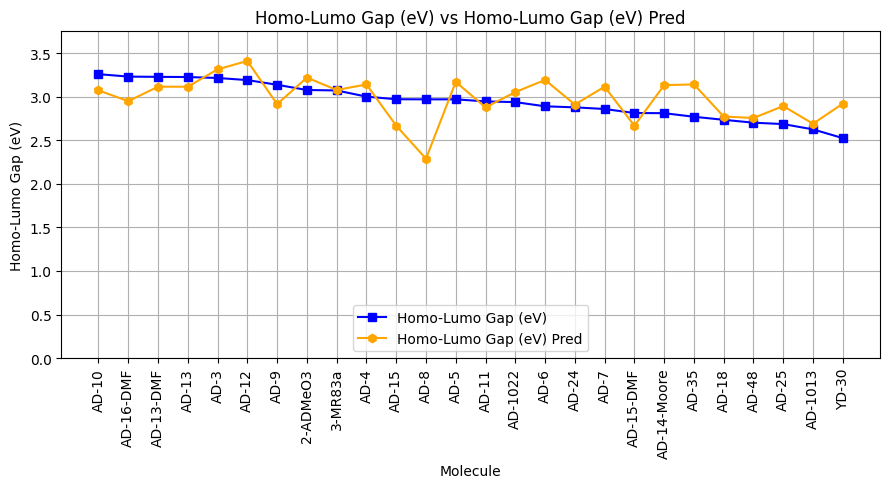

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 4))
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Homo-Lumo Gap (eV)', color='blue')
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred[f'Homo-Lumo Gap (eV) Pred'], marker='h', label=f'Homo-Lumo Gap (eV) Pred', color='orange')
plt.xlabel('Molecule')
plt.ylabel('Homo-Lumo Gap (eV)')
plt.grid(True)
plt.tight_layout()
plt.title(f'Homo-Lumo Gap (eV) vs Homo-Lumo Gap (eV) Pred')
plt.legend()
plt.legend(loc='lower center')

In [111]:
x = similarity_dfs_similarity_morgan_tanimoto_top30.iloc[:, 4:]
y = similarity_dfs_similarity_morgan_tanimoto_top30['GAP_calib']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)

# Initialize and train the LightGBM model
model = lgb.LGBMRegressor(**tuned_params)
model.fit(x_train, y_train)

# Make predictions and calculate R^2 score
y_pred = model.predict(x_test)

# Calculate R2 score
r2_model = r2_score(y_test, y_pred)
from sklearn.metrics import mean_squared_error
rmse_model = mean_squared_error(y_test, y_pred, squared=False)

curcumin_df_mf_pred = curcumin_df_mf.copy()
curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 6:])

r2_predict = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])

print(f"Model similarity_morgan_tanimoto R2 Score: {r2_model} & RMSE value: {rmse_model}")
print(f"Prediction with similarity_morgan_tanimoto model R2 Score: {r2_predict} & RMSE value: {rmse_predict}")                                           

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 11690, number of used features: 1151
[LightGBM] [Info] Start training from score 2.764779
Model similarity_morgan_tanimoto R2 Score: 0.9398020190041924 & RMSE value: 0.14614475789047782
Prediction with similarity_morgan_tanimoto model R2 Score: -0.42051782594244336 & RMSE value: 0.058863854753810944


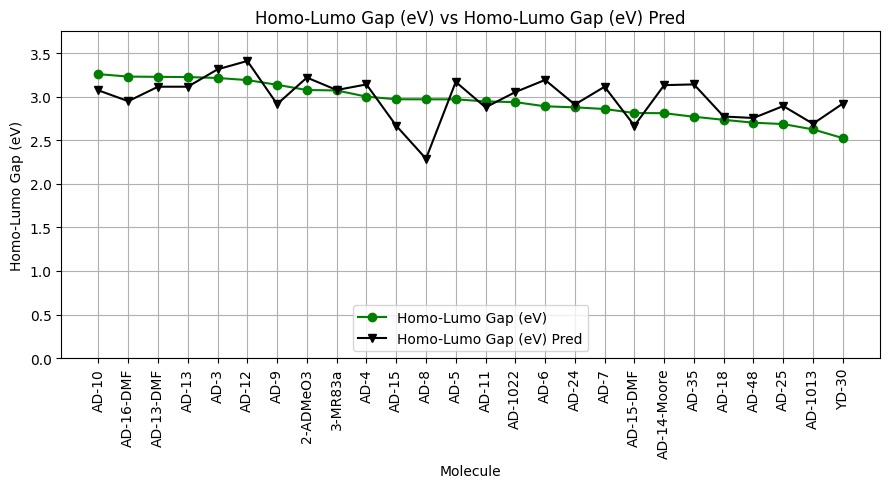

In [112]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 4))
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='o', label='Homo-Lumo Gap (eV)', color='green')
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred[f'Homo-Lumo Gap (eV) Pred'], marker='v', label=f'Homo-Lumo Gap (eV) Pred', color='black')
plt.xlabel('Molecule')
plt.ylabel('Homo-Lumo Gap (eV)')
plt.grid(True)
plt.tight_layout()
plt.title(f'Homo-Lumo Gap (eV) vs Homo-Lumo Gap (eV) Pred')
plt.legend()
plt.ylim(0, 3.75)
plt.legend(loc='lower center')
plt.xticks(rotation=90)
plt.show()

In [113]:
x = similarity_dfs_similarity_maccs_kulczynski_top30.iloc[:, 4:]
y = similarity_dfs_similarity_maccs_kulczynski_top30['GAP_calib']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)

# Initialize and train the LightGBM model
model = lgb.LGBMRegressor(**tuned_params)
model.fit(x_train, y_train)

# Make predictions and calculate R^2 score
y_pred = model.predict(x_test)

# Calculate R2 score
r2_model = r2_score(y_test, y_pred)
from sklearn.metrics import mean_squared_error
rmse_model = mean_squared_error(y_test, y_pred, squared=False)

curcumin_df_mf_pred = curcumin_df_mf.copy()
curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 6:])

r2_predict = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])

print(f"Model similarity_maccs_kulczynski R2 Score: {r2_model} & RMSE value: {rmse_model}")
print(f"Prediction with similarity_maccs_kulczynski model R2 Score: {r2_predict} & RMSE value: {rmse_predict}")                                           

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2278
[LightGBM] [Info] Number of data points in the train set: 11697, number of used features: 1139
[LightGBM] [Info] Start training from score 2.777426
Model similarity_maccs_kulczynski R2 Score: 0.9364081010414715 & RMSE value: 0.14527166736579736
Prediction with similarity_maccs_kulczynski model R2 Score: -2.3031114967937163 & RMSE value: 0.136875350546137


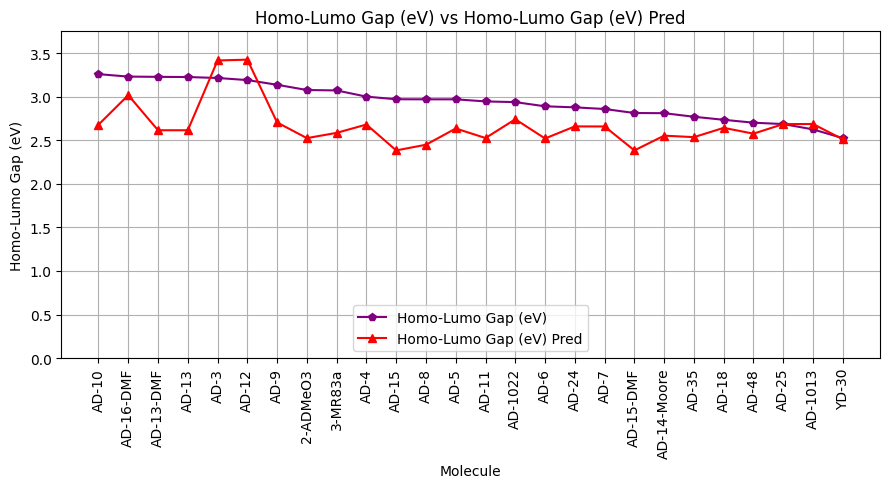

In [115]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 4))
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='p', label='Homo-Lumo Gap (eV)', color='purple')
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred[f'Homo-Lumo Gap (eV) Pred'], marker='^', label=f'Homo-Lumo Gap (eV) Pred', color='red')
plt.xlabel('Molecule')
plt.ylabel('Homo-Lumo Gap (eV)')
plt.grid(True)
plt.tight_layout()
plt.title(f'Homo-Lumo Gap (eV) vs Homo-Lumo Gap (eV) Pred')
plt.legend()
plt.ylim(0, 3.75)
plt.legend(loc='lower center')
plt.xticks(rotation=90)
plt.show()